<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [1]:
import numpy as np      
import pandas as pd     

import matplotlib.pyplot as plt  

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
past = pd.read_csv('../dat/past.csv.gz')
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

In [3]:
past.head()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.00,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.25,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.00,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.25,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.25,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0


2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the perspective of classification, is the data balanced?

In [4]:
# YOUR CODE HERE
print("Percentage of Purchases: ",past['Purchased?'].value_counts()[1] *100 / past['Purchased?'].value_counts().sum())
print("Average of views per purchase: ",past[past['Purchased?'] == 1]['NumView'].mean())

Percentage of Purchases:  34.38
Average of views per purchase:  0.9183940652156454


3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [5]:
X = past.drop(['product_id', 'user_id'], axis=1)
y = X.pop('Purchased?')

In [6]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [7]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X_scaled)

In [8]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [9]:
pca.explained_variance_ratio_

array([0.10282247, 0.09445034, 0.06516473, 0.05108763, 0.04292726])

6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [10]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [11]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

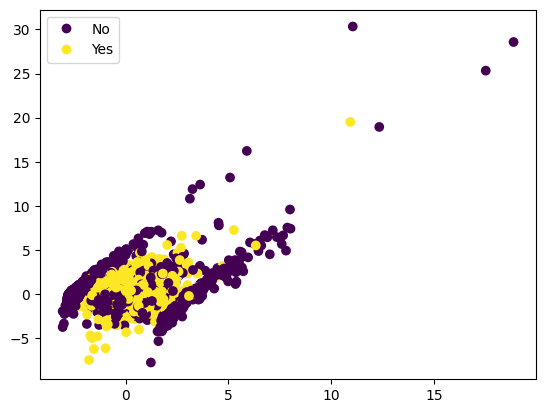

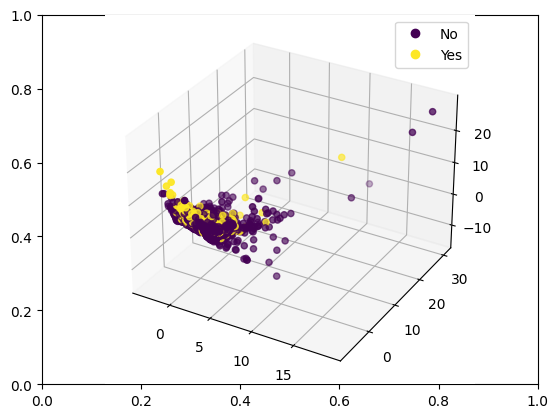

In [12]:
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [13]:
def train(X, y, standardize = True) -> None:
    if standardize:
        X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = LogisticRegression(class_weight='balanced', random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

Now apply the pipeline on the all the features `X` and review the performance

In [14]:
train(X, y)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       649
           1       0.55      0.52      0.54       351

    accuracy                           0.68      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.68      0.68      0.68      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [15]:
train(X_reduced, y)

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       649
           1       0.51      0.55      0.53       351

    accuracy                           0.66      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.66      0.66      0.66      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate.

    *We thought the X and X_reduced evaluation metrics would be different. But they seem to be the same. Purhaps this model smaller or more efficient. Possibly reducing complexity and avoiding overfitting (that comes with complex high-dimensional data)*

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [16]:
from sklearn.cluster import KMeans

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [17]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        inertias.append(kmeans.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

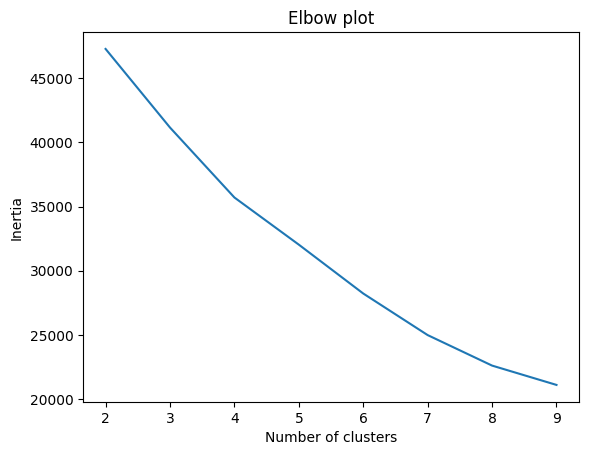

In [18]:
visualize_elbow(X_reduced, range(2, 10))

4. What are the disadvantage to use the Elbow method? 

    This method is sometimes difficult to "eyeball" 

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [19]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.248165793194669
For n_clusters = 3 The average silhouette_score is : 0.2555801654397029
For n_clusters = 4 The average silhouette_score is : 0.26906300886617046
For n_clusters = 5 The average silhouette_score is : 0.23613322450581956
For n_clusters = 6 The average silhouette_score is : 0.23920057635028052
For n_clusters = 7 The average silhouette_score is : 0.24525003206135662
For n_clusters = 8 The average silhouette_score is : 0.2594540180961453


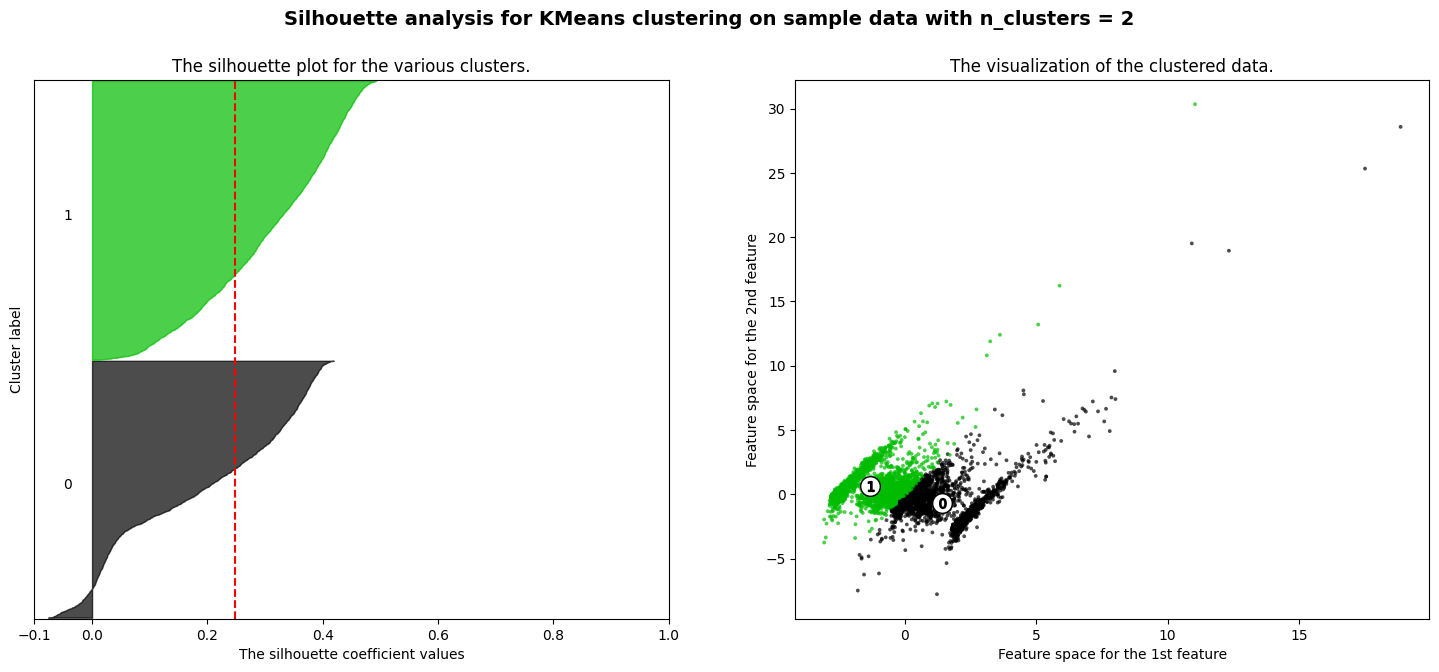

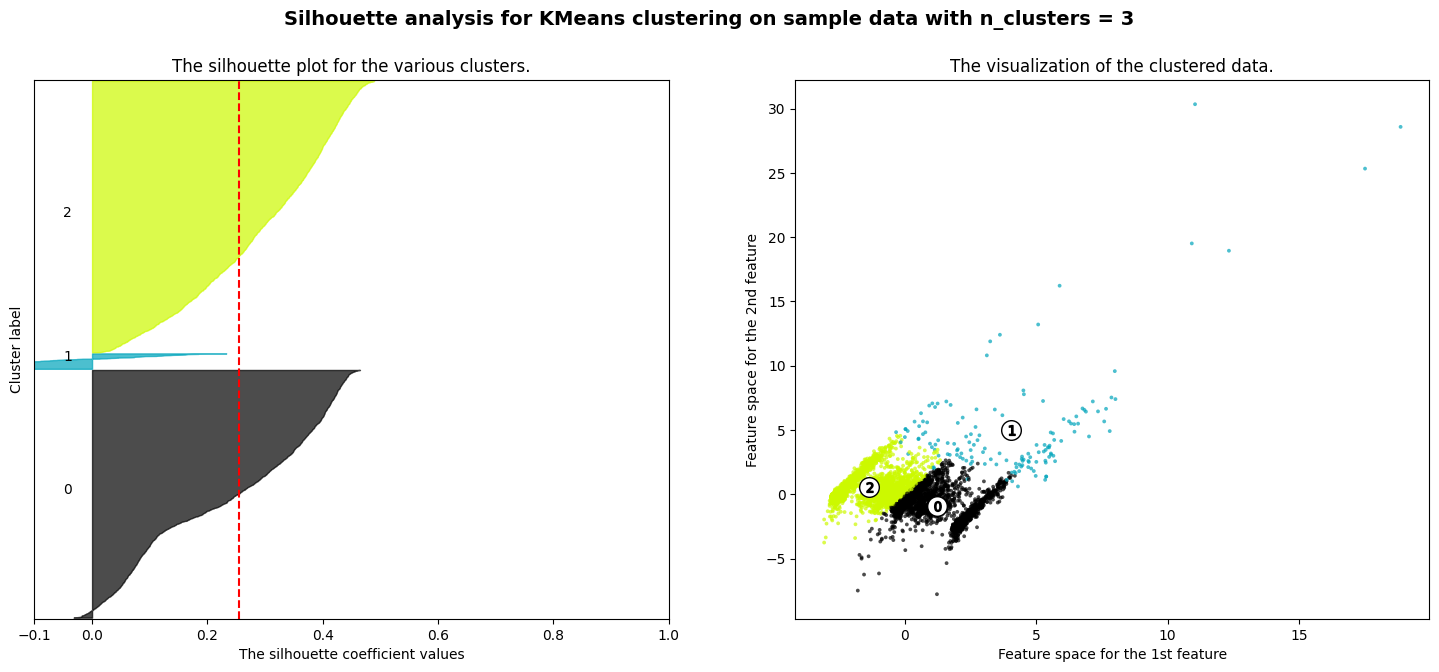

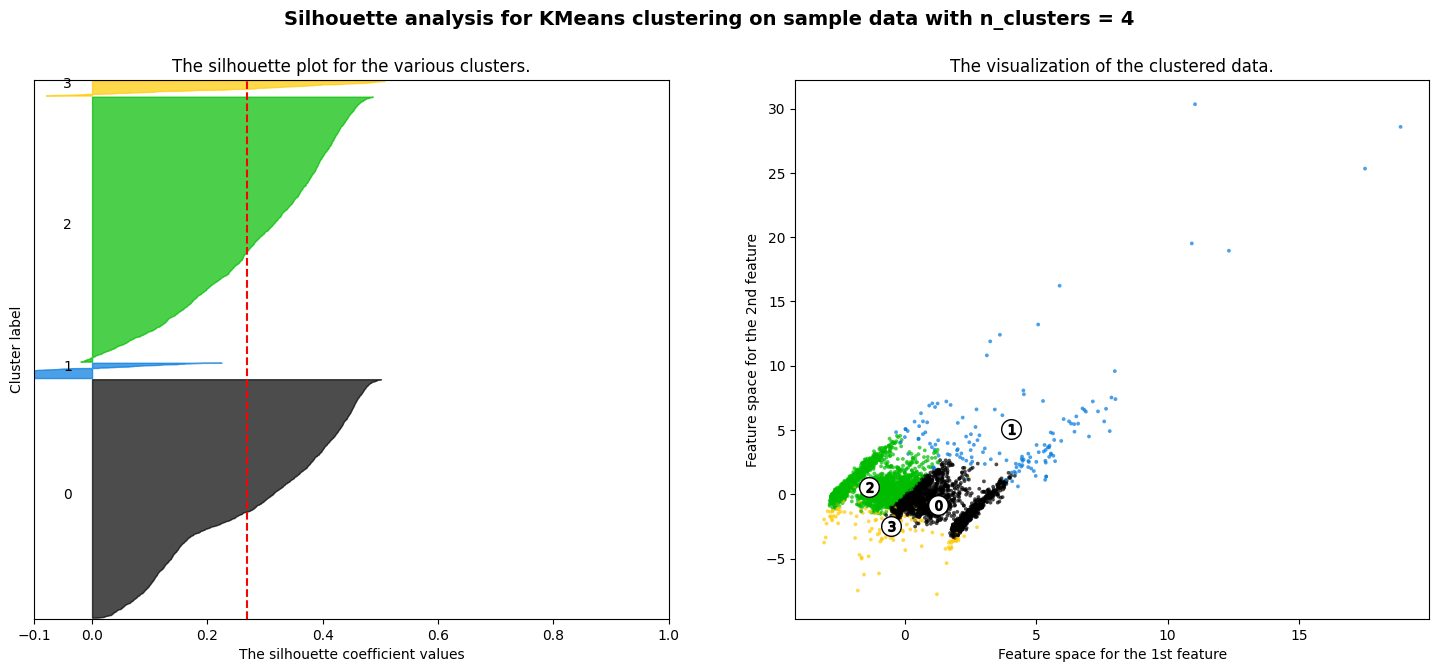

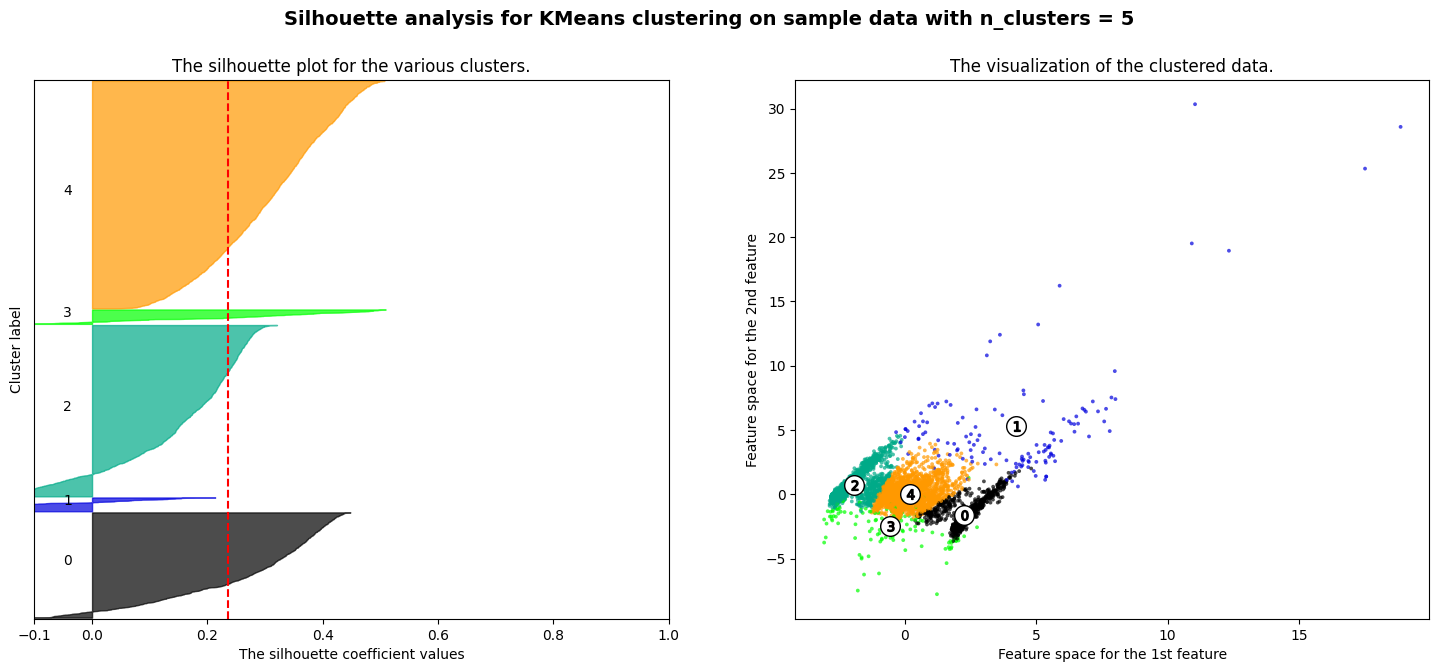

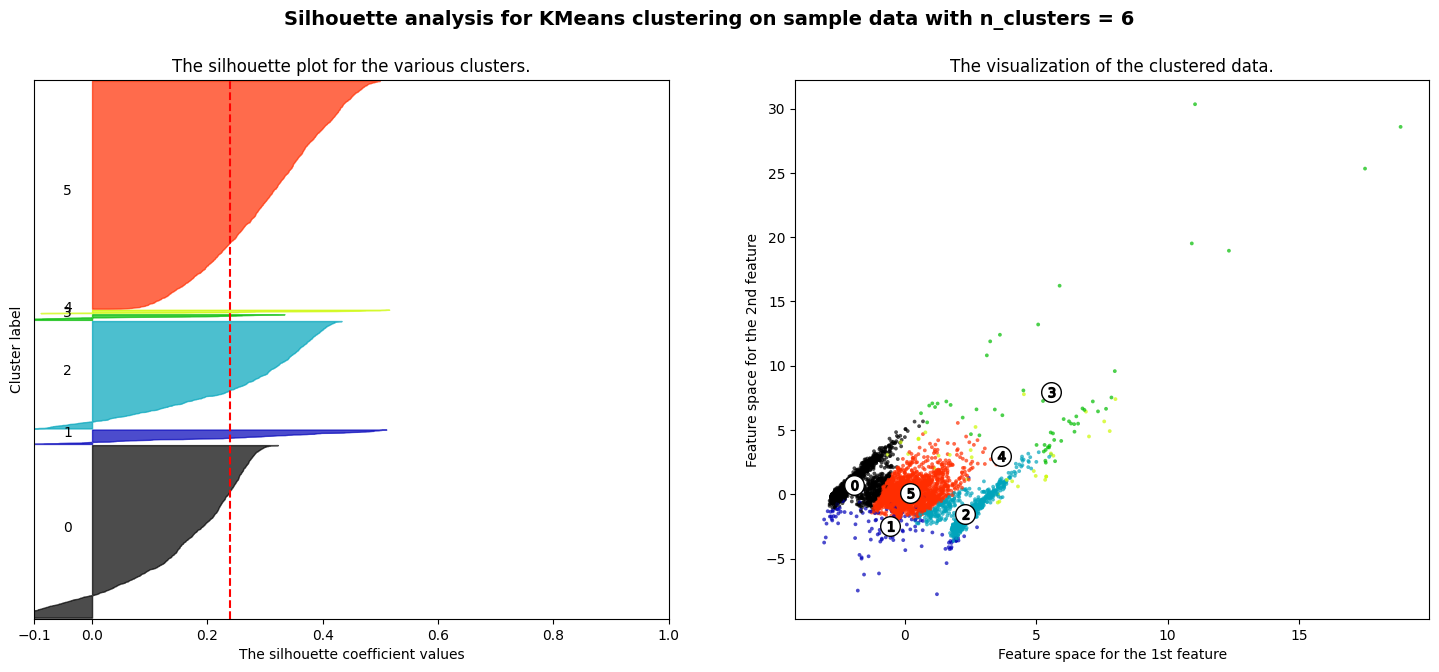

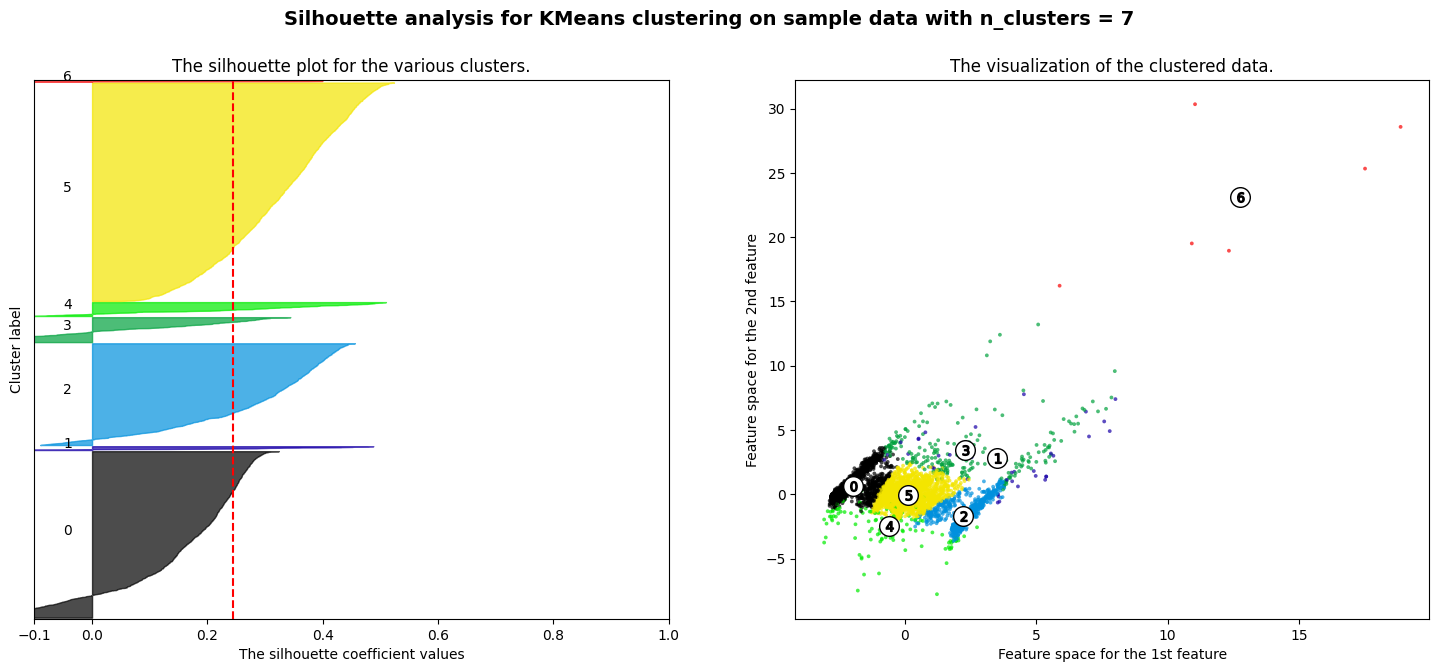

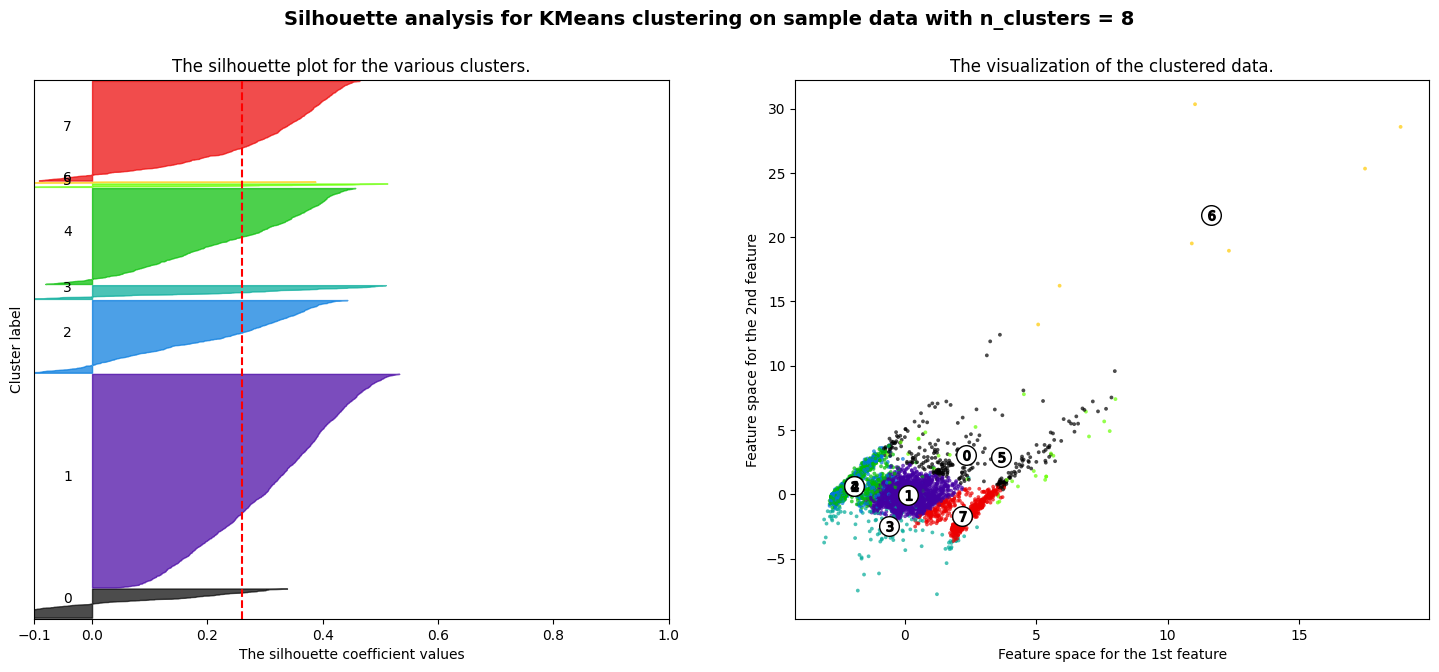

In [20]:
visualize_silhouette(8, X_reduced)

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [21]:
km = KMeans(n_clusters=4, random_state=10)
km.fit(X_reduced)

KMeans(n_clusters=4, random_state=10)

7. What is the size of each cluster? 

In [22]:
unique_clusters, cluster_counts = np.unique(km.labels_, return_counts=True)
print('Cluster counts:', dict(zip(unique_clusters, cluster_counts)))

Cluster counts: {0: 2235, 1: 144, 2: 2483, 3: 138}


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [23]:
past['cluster_pca'] = km.labels_

In [24]:
past[past.cluster_pca==0].describe()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,2.235000e+03,2.235000e+03,2235.000000,2235.000000,2.235000e+03,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,...,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.0
mean,5.598182e+06,5.334500e+08,1.827548,1.273523,2.021145e+05,6.385668,6.356209,0.506612,0.860236,0.362558,...,0.219402,0.063858,0.158988,0.250163,0.165996,0.081843,0.336913,0.059750,1.105046,0.0
std,1.125308e+06,5.844768e+07,0.796994,0.362538,4.702718e+05,5.938920,5.920228,0.435588,0.541714,0.471871,...,0.277766,0.167705,0.236049,0.283783,0.243730,0.178298,0.472761,0.151359,0.309642,0.0
min,4.185000e+03,1.219156e+08,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,5.770338e+06,5.079359e+08,1.000000,1.000000,0.000000e+00,2.620000,2.599615,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,5.839287e+06,5.407843e+08,1.714286,1.157895,2.346500e+03,4.640909,4.600000,0.500000,1.000000,0.200000,...,0.142857,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,5.884400e+06,5.718239e+08,2.200000,1.500000,1.880237e+05,7.706667,7.620000,0.833333,1.000000,0.550862,...,0.333333,0.037269,0.250000,0.400000,0.250000,0.090909,1.000000,0.045455,1.000000,0.0
max,5.932538e+06,6.220262e+08,5.500000,4.000000,4.958619e+06,35.560000,35.560000,4.500000,4.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.0


In [25]:
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category', 'cluster_pca'],
      dtype='object')

In [26]:
past.groupby('cluster_pca')['NumOfEventsInJourney','NumSessions','interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',].mean()

/tmp/ipykernel_507/1548926978.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  past.groupby('cluster_pca')['NumOfEventsInJourney','NumSessions','interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',].mean()


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView
cluster_pca,,,,,,,
0,1.827548,1.273523,2.021145e+05,6.385668,6.356209,0.506612,0.860236
1,5.596308,3.024477,2.343516e+06,4.730586,4.497756,1.581520,1.953544
2,1.878484,1.285355,1.781229e+05,5.624517,5.604361,0.536685,0.844129
3,1.454230,1.173008,9.888010e+04,60.646039,60.595441,0.124334,1.221189


In [ ]:
# for each cluster, train the model on the reduced data by splicing the data by cluster
for cluster in past.cluster_pca.unique():
    print(f'Cluster {cluster}')
    train(X_reduced[past.cluster_pca==cluster], y[past.cluster_pca==cluster])
# output below

9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

    Once we seperate into individual clusters we can perform the same analysis on each cluster and determine if any having a higher purchase rate than others or if any features are more prominent in a particular cluster. We can then use this information to target specific customers with specific products.

Cluster 0

              precision    recall  f1-score   support

           0       0.87      0.64      0.74       306
           1       0.50      0.79      0.62       141

    accuracy                           0.69       447

    macro avg      0.69      0.72      0.68       447
   
    weighted avg   0.75      0.69      0.70       447

Cluster 2

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       316
           1       0.66      0.81      0.72       181

    accuracy                           0.78       497
    macro avg      0.77      0.78      0.77       497
    weighted avg   0.79      0.78      0.78       497

Cluster 3

               precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.67      0.60      0.63        10

    accuracy                           0.75        28
    macro avg      0.73      0.72      0.72        28
    weighted avg   0.75      0.75      0.75        28

Cluster 1

              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.46      0.67      0.55         9

    accuracy                           0.66        29
    macro avg      0.64      0.66      0.63        29
    weighted avg   0.70      0.66      0.67        29

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

    K-Means is limited in its ability to cluster non-spherical data. It also requires the number of clusters to be known in advance. It is also sensitive to outliers and noise.

In [31]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(random_state=10).fit(X_reduced)
ap_unique, ap_counts = np.unique(ap.labels_, return_counts=True)
print("Affinity Prop Cluster Labels\n",ap_unique)
print("Affinity Prop Cluster Counts\n",ap_counts)

Affinity Prop Cluster Labels
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195]
Affinity Prop Cluster Counts
 [ 89   1  13  19  13  16  65   8   4   3  10 101  29  81  57  26  38  24
   9  26   1   1   8   1  19  26  37  36  41  20   3  56  39   1   1  3

11. Jot down recommendations or followup steps, detailing the reasons.

    With the information we have we can target customers with specific products based on their cluster. The differences in clustering algorithms comes down to the assumptions they make about the data. K-Means assumes spherical clusters and that the number of clusters is known. Affinity-Propogation and DBSCAN assume that the clusters are not spherical and that the number of clusters is unknown. We can use this information to target customers with specific products based on their cluster.

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [32]:
new = pd.read_csv('../dat/new.csv.gz')

In [33]:
assert new.shape == (30091, 5)

In [34]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

In [35]:
past.shape

(5000, 38)

    Training set (past) has 5000 rows and 38 columns. Test set (new) has 30091 rows and 5 columns. 

    The number of datapoints in the training set is relatively small while the test set is quite large. The training set has more features than in the test set.

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [38]:
np.intersect1d(new.product_id, past.product_id).shape

(0,)

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [50]:
new['Purchased?'].mean() # ~.344

0.3442557575354757

5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [53]:
feature_cols = ['maxPrice','minPrice','Category']
X_train, y_train, X_test, y_test = past[feature_cols].values, past['Purchased?'].values, new[feature_cols].values, new['Purchased?'].values

In [54]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [56]:
model = LogisticRegression(class_weight='balanced', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [59]:
X = pd.concat([past[feature_cols], new[feature_cols]])

In [60]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [64]:
y = pd.concat([past['Purchased?'], pd.Series(30091*[-1])])

In [65]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [73]:
from sklearn.semi_supervised import LabelSpreading
ls = LabelSpreading(alpha=0.01, kernel='knn')
ls.fit(X, y)
ls

LabelSpreading(alpha=0.01, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [85]:
semi_sup_preds = ls.transduction_[:30091]

In [86]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [87]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.66      0.72      0.69     19732
           1       0.35      0.28      0.31     10359

    accuracy                           0.57     30091
   macro avg       0.50      0.50      0.50     30091
weighted avg       0.55      0.57      0.56     30091



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



LabelSpreading areas of improvement:

- Precision is low for both classes
- Recall is low for class 0
- F1-score is low for class 0

Reasons for improvement:

- The model is not able to predict the negative class well
- The model is not able to predict the positive class well

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)